In [1]:
# Given the training loss and val loss from before
# train loss : 2.0583250522613525
# val loss : 2.1065292358398438
#
# we can see that the losses are very similar
# so we can see that we are not overfitting too much
#
# so we can try to get better performance by scaling up the size of the NN
# bigger and deeper
#
# the model we are using is a simple 1 hidden layer MLP
# we don't have a naive way of making it bigger in a productive way
# of course we can make the model deeper
# but it doesn't take way from the fact that we are forcing
# all our examples to be crammed into the first layer right in the beginning
# It's kind silly to squash all that information SO FAST even if we increase the size of the first layer
#
# What we want our network to look like is Wavenet
# In wavenet the inputs are not all crushed directly to one layer
# Instead they are crushed lot more slowly
# 2 characters are fused in one layers, the next fused the ones from the other 2*2, and so on
# dilated causal convolutional layers
# the basic idea is progressive fusion


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import torch
import torch.nn.functional as F

In [4]:
words = open('names.txt').read().splitlines()
len(words), words[:8]

(32033,
 ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'])

In [5]:
# let's only have one special token, and let's have it at index 0, offset others by 1
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
num_classes = len(stoi)
vocab_size = len(itos)
print(vocab_size, itos)

27 {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
def build_dataset(words, block_size):
    X, Y, = [], [] # X, input | Y, labels

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append moving window

    X = torch.tensor(X)
    Y = torch.tensor(Y)    
    return X, Y

In [7]:
# Splits
import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

block_size = 8 # context length : How many characters do we take to predict the next one : 3 chars to predict the 4th

Xtr, Ytr = build_dataset(words[:n1], block_size)
Xva, Yva = build_dataset(words[n1:n2], block_size)
Xte, Yte = build_dataset(words[n2:], block_size)

Xtr.shape, Ytr.shape, Xva.shape, Yva.shape, Xte.shape, Yte.shape

(torch.Size([182625, 8]),
 torch.Size([182625]),
 torch.Size([22655, 8]),
 torch.Size([22655]),
 torch.Size([22866, 8]),
 torch.Size([22866]))

In [8]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '--->', itos[y.item()])

........ ---> y
.......y ---> u
......yu ---> h
.....yuh ---> e
....yuhe ---> n
...yuhen ---> g
..yuheng ---> .
........ ---> d
.......d ---> i
......di ---> o
.....dio ---> n
....dion ---> d
...diond ---> r
..diondr ---> e
.diondre ---> .
........ ---> x
.......x ---> a
......xa ---> v
.....xav ---> i
....xavi ---> e


In [9]:
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1D:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # learnable parameters
        self.gamma = torch.ones(dim)  # gain
        self.beta  = torch.zeros(dim) # bias
        # buffers (calculated with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var  = torch.ones(dim)
        
    def __call__(self, x):
        # forward pass
        if self.training:
            xmean = x.mean(dim=0, keepdim=True)
            xvar  = x.var(dim=0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar  = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        # updating running buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var  = (1 - self.momentum) * self.running_var + self.momentum * xvar
                
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []


class Embedding:
    def __init__(self, num_embeddings, embeddings_dim):
        self.weight = torch.randn((num_embeddings, embeddings_dim))
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
    

# class Flatten:
#     def __call__(self, x):
#         self.out = x.view(x.shape[0], -1)
#         return self.out
    
#     def parameters(self):
#         return []
    
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n
        
    def __call__(self, x):
        B, T, C = x.shape # batch,  ....., embedding
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:  # squeeze out spurious dimension
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []

class Sequential:
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [18]:
torch.manual_seed(42);

In [11]:
# Lets run the wavenet style model

In [12]:
n_embed = 10   # dimensionality of characters in the embedding vector
n_hidden = 68  # number of neurons in the hidden layer

# stack up the layers
model = Sequential([
    Embedding(vocab_size, n_embed),
    FlattenConsecutive(2), Linear(n_embed * 2, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# initialisation
with torch.no_grad():
    # make last layer less confident
    model.layers[-1].weight *= 0.1

# prepare parameters, no need to check for C and the concat
parameters = model.parameters()
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

22397


In [13]:
max_steps = 200000
batch_size = 32

In [14]:
# Forward pass also gets simplified

In [15]:
lossi = []
stepsi = []
tot_steps = len(stepsi)

for i in range(max_steps):
    # construct minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)  # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 150000 else 0.01    # switch learning rate
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    stepsi.append(tot_steps+i)
    lossi.append(loss.item())
    
    # Print loss 
    if (i)%(max_steps/10) == 0:
        print(f"Loss {i}/{max_steps}: {loss.item()}")


Loss 0/200000: 3.2871856689453125
Loss 20000/200000: 2.3181662559509277
Loss 40000/200000: 2.407486915588379
Loss 60000/200000: 1.8901737928390503
Loss 80000/200000: 1.9360038042068481
Loss 100000/200000: 1.9132928848266602
Loss 120000/200000: 1.9422024488449097
Loss 140000/200000: 2.018550395965576
Loss 160000/200000: 2.6426162719726562
Loss 180000/200000: 1.6862258911132812


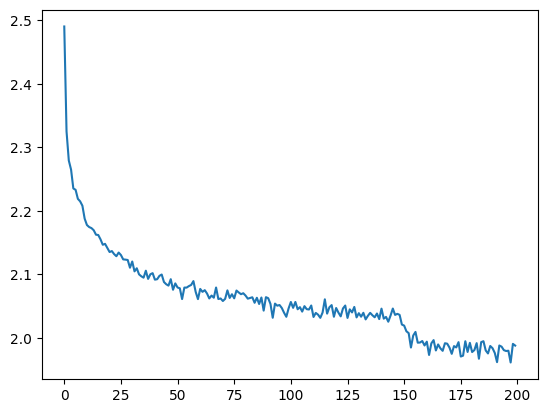

In [16]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

In [17]:
# Set model in eval mode (mostly to be able to use batchnorm)
for layer in model.layers:
    layer.training = False

In [18]:
@torch.no_grad() # this decorator disables gradient tracking, can also the context manager instead
def split_loss(split):
    ds = {
        'train': (Xtr, Ytr),
        'val':   (Xva, Yva),
        'test':  (Xte, Yte),
    }
    x,y = ds[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss : {loss.item()}')

split_loss('train')
split_loss('val')

train loss : 1.9449892044067383
val loss : 2.0315096378326416


In [19]:
for _ in range(20):
    out = []
    context = [0] * block_size # initialize all with ...
    while True:
        # forward pass
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1) # exponentiates the logits and then softmaxes them, similar to cross entroy no overflows
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # break if we reach the special token '.'
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

drianna.
michayline.
kopitra.
kimbarise.
taelij.
camran.
giagarion.
carlyle.
amariah.
dayron.
tinch.
sutay.
mailana.
kathton.
kamrida.
shyliyah.
yeiven.
harioha.
axibitt.
fastel.


In [20]:
# Note our losses going down with tricks

# Train test validation split - in the beginning
# Train Loss : 2.2589
# Val Loss   : 2.2702

# After increasing NN capacity and embedding size
# Train Loss : 2.1190
# Val Loss   : 2.1711

# After fixing init weight bias softmax confidently wrong
# Train loss : 2.0695
# Val loss   : 2.1310

# After fixing tanh saturation
# train loss : 2.0355
# val loss   : 2.1026

# Now, with kaiming init and not using magic numbers for tanh saturation
# train loss : 2.0376
# val loss   : 2.1069

# With batch norm
# train loss : 2.0668
# val loss   : 2.1048

# With manual backprop
# train loss : 2.176852226257324
# val loss : 2.1903560161590576

# With increase context length to 8
# train loss : 1.9163434505462646
# val loss : 2.034247875213623

# With switch from flat MLP to hiearchical layers
# train loss : 1.9449892044067383
# val loss : 2.0315096378326416

In [21]:
# Not really a reasonable change between the flat vs. hiarchical network yet

In [22]:
# Before we look into that, lets check if the batchnorm is working correctly
# The models runs, but is it working as expected ????